In [59]:
# Import dependencies
!pip install torchdiffeq
import argparse
import time
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import matplotlib.pyplot as plt
from numpy import zeros, newaxis
import random
import torch.nn.functional as F
# Adjoint method is not necessary for 
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
# Print whether CPU or GPU is used.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
from google.colab import drive
drive.mount('/content/drive/')

tlength =  3 # fill in the blank Length of time sections
rangemax = 20  ## No. of initial conditions
timemax = 200-tlength ## length of each time series
intest = random.sample(range(1,rangemax), 6) ## index for test data
intrain = np.setdiff1d(range(1,rangemax),intest) ## index for training data

print(intest)
print(intrain)
Xtrain = np.array([0,0,0])
Xtest = np.array([0,0,0])
Xall = np.array([0,0,0])
Ytrain = np.array([0])
Ytest = np.array([0])
Yall = np.array([0])
intrain = 0
for iter in range(1,rangemax):
  randstring = str(iter)
  image_array= sio.loadmat('/content/drive/My Drive/mae259b_hw3_f2022/theta_'+randstring+'.mat')
  thetaall= image_array['thetaoutall']

  for ii in range(0,timemax):
    Xall = np.vstack([Xall,thetaall[0,ii:ii+tlength]])
    Yall = np.vstack([Yall,thetaall[0,ii+tlength]])
    if iter in intest:
      Xtest = np.vstack([Xtest,thetaall[0,ii:ii+tlength]])
      Ytest = np.vstack([Ytest,thetaall[0,ii+tlength]])
    else:

      Xtrain = np.vstack([Xtrain,thetaall[0,ii:ii+tlength]])
      Ytrain = np.vstack([Ytrain,thetaall[0,ii+tlength]])
print(Xtrain.shape)
print(Ytest.shape)

Xtest = Xtest[1:,:]
Ytest = Ytest[1:,:]
Xtrain = Xtrain[1:,:]
Ytrain = Ytrain[1:,:]
Xall = Xall[1:,:]
Yall = Yall[1:,:]

## Let's check the data size
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[19, 10, 13, 3, 8, 11]
[ 1  2  4  5  6  7  9 12 14 15 16 17 18]
(2562, 3)
(1183, 1)
(2561, 3)
(2561, 1)
(1182, 3)
(1182, 1)


In [61]:
## TRANSFORM TO PYTORCH TENSOR


xtrain = torch.from_numpy(Xtrain).requires_grad_(True)
xtest = torch.from_numpy(Xtest).requires_grad_(True)

ytrain = torch.from_numpy(Ytrain).requires_grad_(True)
ytest = torch.from_numpy(Ytest).requires_grad_(True)
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

torch.Size([2561, 3])
torch.Size([2561, 1])
torch.Size([1182, 3])
torch.Size([1182, 1])


In [62]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        numhid = 1000 ## fill in the blank, number of hidden layer
        self.fc1 = nn.Linear(tlength, numhid) ## Applies a linear transformation to the incoming data, fully connected
        self.fc2 = nn.Linear(numhid, numhid)
        self.fc3 = nn.Linear(numhid, numhid)
        self.fc4 = nn.Linear(numhid, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=3, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=1000, bias=True)
  (fc4): Linear(in_features=1000, out_features=1, bias=True)
)


Select smaller sizes

In [63]:
print(xtrain.shape)

torch.Size([2561, 3])


In [64]:
train = torch.utils.data.TensorDataset(xtrain,ytrain)
train_loader = torch.utils.data.DataLoader(train, batch_size= 128, shuffle=False)# fill in the blank, batch size

train = torch.utils.data.TensorDataset(xtest,ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size= 128, shuffle=False)

In [65]:
import torch.optim as optim

loss_function = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.01,  weight_decay=1e-5) # fill in the blank, lr is the learning rate
lossall_train=[]
for epoch in range(300): #fill in the blank, number of full passes over the data
    for data in train_loader:  # data is a batch of data
        X, y = data  # X is the batch of features, y is the batch of targets.
        net.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.float())  # pass in the reshaped batch 
        loss = loss_function(output, y.float())  # loss value Cross entropy loss

        loss.backward()  # apply this loss backwards thru the network's parameters
        
        optimizer.step()  # attempt to optimize weights to account for loss/gradients 
    lossall_train=lossall_train+[loss.detach().numpy()]
    
    #print(loss)  # print loss. We hope loss (a measure of wrong-ness) declines! 

Let's check the loss

Text(0, 0.5, 'Loss')

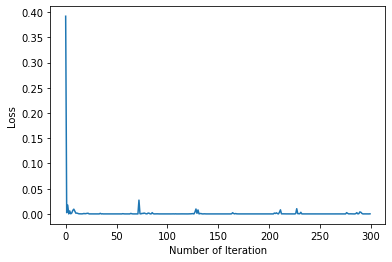

In [71]:
plt.plot(lossall_train)
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")

Finally, let's check the predicted value

In [67]:
ypred = net(xtest.float())


Text(0, 0.5, 'Prediction')

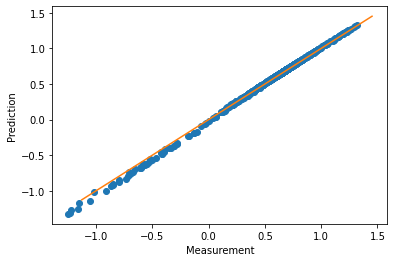

In [68]:
plt.plot(ytest.detach().numpy(),ypred.detach().numpy() ,'o')
plt.plot([np.min(ytest.detach().numpy())*.9,np.max(ytest.detach().numpy())*1.1],[np.min(ytest.detach().numpy())*.9,np.max(ytest.detach().numpy())*1.1])
plt.xlabel('Measurement')
plt.ylabel('Prediction')
